# Import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy 
from scipy.stats import ttest_ind
import itertools

In [2]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

## Prep

In [3]:
#Takes in list of pairs and makes them a dictionary
def pairs_to_map(pairs):
    dic = {}
    for pair in pairs:
        key, value = pair
        dic[key] = value
    return lambda x: dic[x]

In [4]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()

#Drop accessories
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Flag unknown brands
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')

#Get branded modules
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]

#Add log_price and log_racks
df_brands['log_price'] = np.log(df_brands['price'])
df_brands['log_racks'] = np.log(df_brands['num_racks'])

#Add popularity ranking of each module
pop_ranker = pairs_to_map([*zip(df_brands.sort_values(by='log_racks').log_racks.unique(),
   range(len(df_brands.sort_values(by='log_racks').log_racks.unique())))])

df_brands['pop_rank'] = df_brands.log_racks.apply(pop_ranker)

#Make dfs exploded over function
df_brands['functions'] = df_brands.tags.str.split('-')
brands_exploded = df_brands.explode('functions')

#Add number of functions each module has
df_brands['num_functions'] = df_brands.functions.apply(len)

#add rank of number of functions of each module
n_func_ranker = pairs_to_map([*zip(df_brands.sort_values(by='num_functions').num_functions.unique(),
   range(len(df_brands.sort_values(by='num_functions').num_functions.unique())))])

df_brands['n_func_rank'] = df_brands.num_functions.apply(n_func_ranker)



#Multi vs. single function flag
df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)

#Known price flag
df_brands['price_known'] = df_brands.price.notnull()


# moduledf['functions'] = moduledf.tags.str.split('-')
# modules_exploded = moduledf.explode('functions')

numeric = ['width', 'price', 'log_price', 'num_racks', 'log_racks', 'pop_rank', 'num_functions', 'n_func_rank']

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/1507949289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf.drop('module_type', axis =1, inplace=True)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/1507949289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf['tags'] = moduledf['tags'].str.lower()
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/1507949289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [5]:
# brand_dummy = pd.get_dummies(df_brands, columns = ['manufacturer_name']).drop(['depth', 'current_plus12V', 'current_minus12V','current_5V'], axis = 1)

In [6]:
df_brands.head()

,manufacturer_name,module_name,width,depth,current_plus12V,current_minus12V,current_5V,price,num_racks,tags,availability,brand_known,log_price,log_racks,pop_rank,functions,num_functions,n_func_rank,multifunction,price_known
4582,000,BSDM BAREBACK KICK,8.0,21.0,15.0,NaN,0.0,180.0,92.0,drum,unknown,True,5.192957,4.521789,91,[drum],1,0,False,True
4583,000,SNORE FIST DRUM,10.0,22.0,NaN,NaN,NaN,210.0,72.0,drum,unknown,True,5.347108,4.276666,71,[drum],1,0,False,True
4584,000,SCAT 0-LOGICAL DISTORTION,6.0,22.0,NaN,NaN,NaN,120.0,107.0,distortion-effect,unknown,True,4.787492,4.672829,106,"[distortion, effect]",2,1,True,True
4585,000,MAYDAY,8.0,22.0,NaN,NaN,NaN,220.0,18.0,clock generator-midi-utility,unknown,True,5.393628,2.890372,17,"[clock generator, midi, utility]",3,2,True,True
4586,000,Giftgiver Filter,6.0,22.0,NaN,NaN,NaN,151.0,18.0,distortion-effect-filter,unknown,True,5.017280,2.890372,17,"[distortion, effect, filter]",3,2,True,True


In [7]:
df_brands[numeric].describe()

,width,price,log_price,num_racks,log_racks,pop_rank,num_functions,n_func_rank
count,7066.000000,6337.000000,6337.000000,7066.000000,7066.000000,7066.000000,7066.000000,7066.000000
mean,11.425984,205.569355,5.009676,750.310784,5.076368,371.739740,2.603029,1.602887
std,10.099868,192.082718,0.821428,2282.390905,1.744566,475.119875,1.618781,1.618178
min,1.000000,4.000000,1.386294,1.000000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,90.000000,4.499810,45.000000,3.806662,44.000000,1.000000,0.000000
50%,8.000000,160.000000,5.075174,142.000000,4.955827,141.000000,2.000000,1.000000
75%,14.000000,259.000000,5.556828,536.750000,6.285532,525.750000,3.000000,2.000000
max,104.000000,3999.000000,8.293800,52604.000000,10.870547,1839.000000,10.000000,8.000000


# Prep data on each brand

In [8]:
brand_data = pd.DataFrame({'manufacturer_name': df_brands.manufacturer_name.unique()})

#Add column for number of unique functions that brand makes
brand_data = brand_data.merge(
    brands_exploded.groupby('manufacturer_name')['functions'].unique().apply(len)\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for number of modules produced by each company
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['module_name'].unique().apply(len)\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for average popularity of all products by brand
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['num_racks'].mean()\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for max popularity of product by brand
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['num_racks'].max()\
        .reset_index(), 
    on = 'manufacturer_name')


brand_data.columns = ['brand', 'n_functions', 'n_modules', 'product_avg_racks', 'product_max_racks']

#Add number and percent of products which are in top 5% most popular products for each brand
top_products = df_brands.sort_values(by = 'num_racks', ascending = False).iloc[:int(0.05 * len(df_brands))+1,:]

brand_data = brand_data.merge(
    top_products.groupby('manufacturer_name')['module_name'].unique().apply(len)\
        .reset_index().rename(columns={'module_name':'n_top_products'}),
    left_on = 'brand',
    right_on = 'manufacturer_name',
    how='left'
).drop('manufacturer_name',axis=1)

brand_data.n_top_products = brand_data.n_top_products.fillna(0)

brand_data['per_top_products'] = brand_data.n_top_products / brand_data.n_modules

brand_data

,brand,n_functions,n_modules,product_avg_racks,product_max_racks,n_top_products,per_top_products
0,000,10,8,60.875000,107.0,0.0,0.000000
1,1010 Music,23,11,1358.090909,5688.0,2.0,0.181818
2,256klabs,5,6,26.000000,51.0,0.0,0.000000
3,2hp,34,96,1870.608247,10928.0,14.0,0.145833
4,4ms Company,29,44,2101.244444,11519.0,9.0,0.204545
...,...,...,...,...,...,...,...
515,VH.S,6,2,20.000000,21.0,0.0,0.000000
516,Wildsync,8,8,30.500000,60.0,0.0,0.000000
517,x1l3,18,11,107.615385,570.0,0.0,0.000000
518,XOXO Modular,6,5,117.800000,427.0,0.0,0.000000


Another question we could ask:

Say that a module is "highly popular" for a function if it is in the top 5% popularity.

Do popular companies with high total popularity have many popular items accross functions, or is it concentrated on a few functions?

Are highly popular items spread across applications or have similar applications?

For each function, what function pairing(s) have highest popularity?

# EDA
modulesdf contains all eurorack modules, even without brand name, with 'accessories' (blank panels, power strips, expanders) dropped. About 20% of all modules are missing price.

brand_df is the subset for modules with brand names listed. About 10% of prices are missing for branded modules.

Some useful but non-obvious business questions: 
1) What functions are optimal for single-use modules? What are their optimal sizes and pricings?
2) What functions are optimal for multi-use modules? What are their optimal sizes and pricings?
3) What are good choices for combinations of functions for multi-use modules? Are certain groupings more popular at certain sizes? What price points are good for that?
4) What 'gaps' might exist for multi-use modules? E.g. popular functions at that size and price point.

These will have to be broken up. We should look at:
-general correlations

a) popularity of different types

b) size distribution of different types

c) price vs popularity

d) for each type, to what extent does price vs size vs brand vs combos predict popularity

Plan:
1. Single variable
- Distribution for price
- Popularity
- Width

2. Categorical variables
- popularity and function

3. Comparison of variables
- correlation between numerical variables
- popularity and price for single vs multifunction
- size against popularity by function and single vs. multifunction
- brand and popularity
- How many/what functions does each brand make? If there is a difference in number of functions each brand makes?

# Single variable stats

## Price and functionality

Price is somewhat log-normal, but has some irregularities.

Mean price is different for single and multifunction modules with p<0.01. For single function modules, log(price) is much closer to normal. However, for multifunction, it is left-skewed. Other factors may be at play, such as number of functions or types of functions.

(array([   7.,   42.,  232.,  567., 1644., 2210., 1277.,  317.,   36.,
           5.]),
 array([1.38629436, 2.07704489, 2.76779541, 3.45854594, 4.14929646,
        4.84004698, 5.53079751, 6.22154803, 6.91229856, 7.60304908,
        8.29379961]),
 <BarContainer object of 10 artists>)

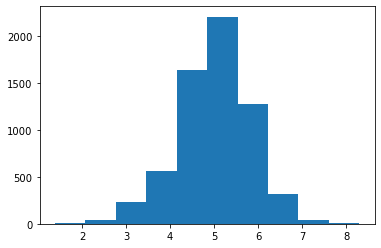

In [9]:
plt.hist(np.log(df_brands.price))

<AxesSubplot:xlabel='price', ylabel='Density'>

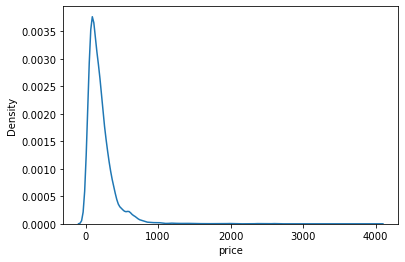

In [10]:
sns.kdeplot(df_brands.price)

We check log_price

<AxesSubplot:xlabel='price', ylabel='Density'>

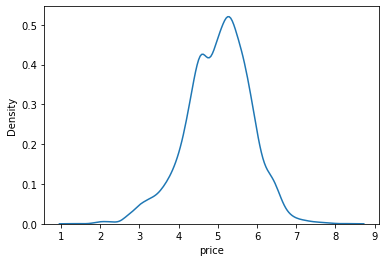

In [11]:
sns.kdeplot(np.log(df_brands.price))

In [12]:
scipy.stats.describe(df_brands.log_price.dropna().values)

DescribeResult(nobs=6337, minmax=(1.3862943611198906, 8.293799608846818), mean=5.009675841278094, variance=0.6747437410949441, skewness=-0.3363614073023695, kurtosis=0.4946002837322361)

In [13]:
mean_log_price, std_log_price = np.log(df_brands[df_brands.price.notnull()].price).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

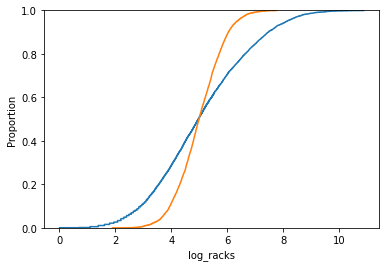

In [14]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_price, scale = std_log_price, size = 5000), ax=ax)

log(price) better behaved, but still not perfectly normal. Like with size, better distributions may hold among subclasses. We first check single vs. multifunction.

Text(0.5, 1.0, 'Multifunction vs. Price')

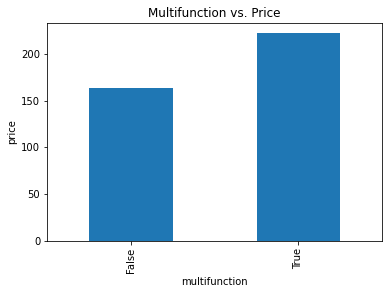

In [15]:
ax = df_brands.groupby('multifunction')['price'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('price')
ax.set_title('Multifunction vs. Price')

In [16]:
multifunction_price = df_brands[df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values
singlefunction_price = df_brands[~df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values

In [17]:
ttest_ind(multifunction_price, singlefunction_price, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=12.468926664514205, pvalue=2.1038616105596615e-35)

We can see that single vs. multifunction come from different price distributions with different means.

In [18]:
single_price_mean, single_price_std = (np.mean(np.log(singlefunction_price)), np.std(np.log(singlefunction_price)))

<AxesSubplot:ylabel='Proportion'>

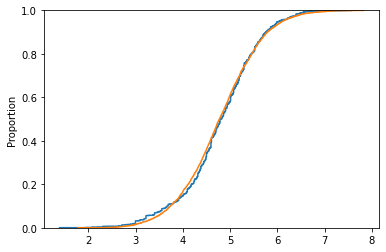

In [19]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = single_price_mean, scale = single_price_std, size = 5000), ax=ax)

Log(price) for single-function is much closer to normal. We now check multifunction.

In [20]:
multi_price_mean, multi_price_std = (np.mean(np.log(multifunction_price)), np.std(np.log(multifunction_price)))

<AxesSubplot:ylabel='Proportion'>

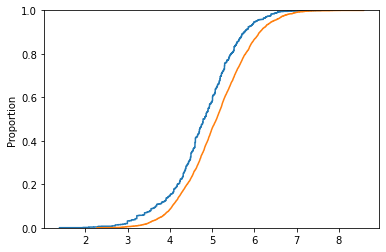

In [21]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = multi_price_mean, scale = multi_price_std, size = 5000), ax=ax)

In [22]:
scipy.stats.describe(np.log(multifunction_price))

DescribeResult(nobs=4531, minmax=(1.9459101490553132, 8.293799608846818), mean=5.099760316272254, variance=0.6457421205565778, skewness=-0.33471108189064325, kurtosis=0.512077292382076)

log_price for multifunction is skewed left

## Popularity
Based on num_racks is almost exactly log-normal. log(num_racks) can be treated like a normally distributed quantity.

<AxesSubplot:ylabel='Frequency'>

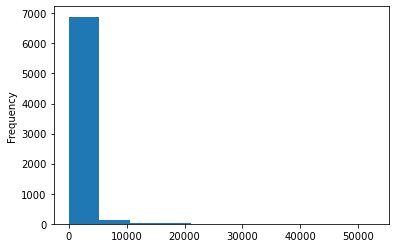

In [23]:
df_brands.num_racks.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

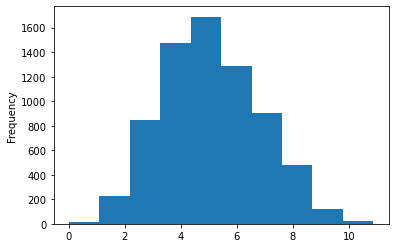

In [24]:
np.log(df_brands.num_racks).plot(kind='hist')

In [25]:
mean_log_pop, std_log_pop = np.log(df_brands.num_racks).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

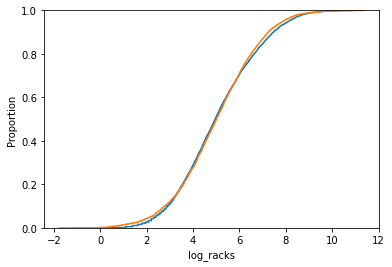

In [26]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_pop, scale = std_log_pop, size = 5000), ax=ax)

log(num_racks) better behaved

## Size (width in hp)

More idiosyncratic distribution. While there are certain highly frequent sizes, the distribution is not (log-)normal, and the frequent sizes aren't necessarily more popular. A typical distribution and correlation with popularity may only hold within certain subgroups, if at all.

However, the distributions of multi and single function modules do have significantly different means, which should be kept in mind when looking at comparisons against width.

<AxesSubplot:ylabel='Frequency'>

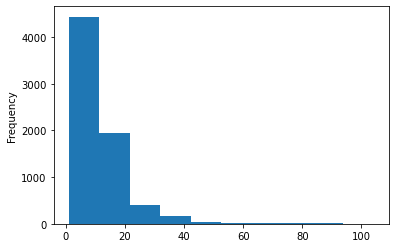

In [27]:
df_brands.width.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

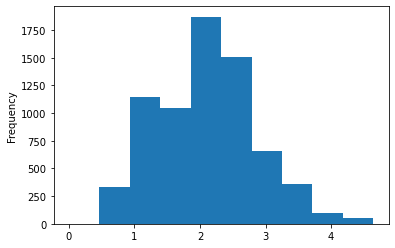

In [28]:
np.log(df_brands.width).plot(kind='hist')

<AxesSubplot:xlabel='width', ylabel='Density'>

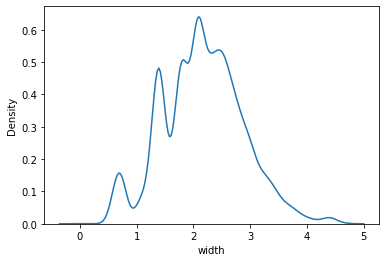

In [29]:
sns.kdeplot(np.log(df_brands.width)) 

Sizes have more unusual distribution. First check against single vs. multifunction.

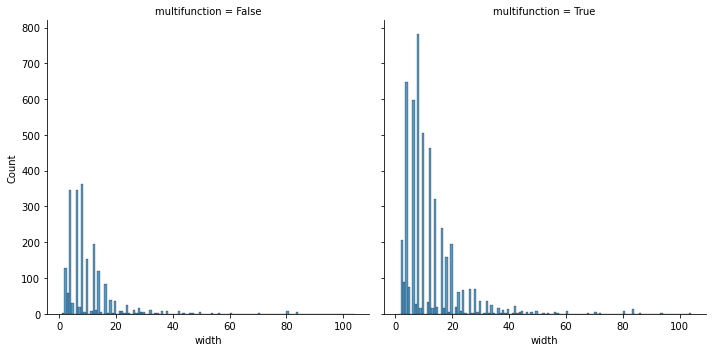

In [30]:
sns.displot(x= 'width', data = df_brands, col = 'multifunction', kind = 'hist', log_scale = False)

Some irregularities are teased apart into the two groups. We look more closely at their distribution, and check that their means are significantly different.

In [31]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

def cutoff(dist):
    return np.percentile(dist,75) + 1.5 * IQR(dist)

In [32]:
df_brands.groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.109948   9.393301  8.0
True           11.982880  10.334958  8.0

In [33]:
df_brands[df_brands.price.notnull()].groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.033776   9.288928  8.0
True           11.834253  10.168541  8.0

Single and multi-use modules have similar width distributions, with multifunction being larger by about 2hp.

We can check if the difference is signficant with a 2-sample ttest with p=0.05.

In [34]:
from scipy.stats import ttest_ind

In [35]:
multifunction_w = df_brands[df_brands.multifunction].loc[:,'width'].values
singlefunction_w = df_brands[~df_brands.multifunction].loc[:,'width'].values

In [36]:
ttest_ind(multifunction_w, singlefunction_w, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=7.431973571153125, pvalue=6.412489290295425e-14)

The result is significant, so we can assume they come from different distributions.

We also note that visual inspection shows some very frequent sizes. It may be that these sizes are 'standards' which skew the distribution. In this way, the frequent sizes may be more like ordered categoricals/classes.

In [37]:
# df_brands.width.value_counts(sort=True, normalize=True).iloc[::-1].plot(kind='barh', figsize = (5,12))

In [38]:
df_brands.width.value_counts(sort=True, normalize=True).head(20)

8.0     0.161902
4.0     0.140815
6.0     0.133456
10.0    0.092980
12.0    0.092980
14.0    0.062412
2.0     0.047269
16.0    0.045429
20.0    0.032692
18.0    0.028022
3.0     0.020804
5.0     0.014718
24.0    0.013020
28.0    0.011746
26.0    0.011180
22.0    0.009765
7.0     0.006652
32.0    0.006652
30.0    0.005944
11.0    0.005661
Name: width, dtype: float64

We can see that after 2hp, the proportion of modules of each size quickly drops below 5% of all modules. Let's check if there are any popularity standouts by width.

In [39]:
df_brands.width.unique().size

62

We look at the popularity of each width for single and multifunction modules

<AxesSubplot:ylabel='width'>

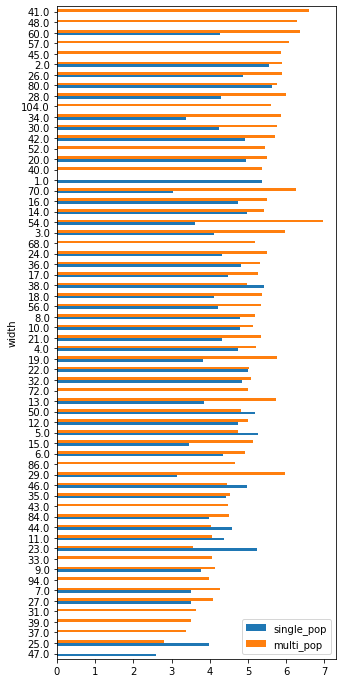

In [40]:
width_pop = df_brands.groupby(['multifunction', 'width'])[['log_racks']]\
                .mean().unstack().T.reset_index('width').reset_index(drop=True)
width_pop.columns = ['width', 'single_pop', 'multi_pop']
width_pop = width_pop.merge(df_brands.groupby('width')[['log_racks']].mean().reset_index(), on = 'width', how='outer')
width_pop.sort_values(by='log_racks').drop('log_racks', axis=1).plot(x = 'width', kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

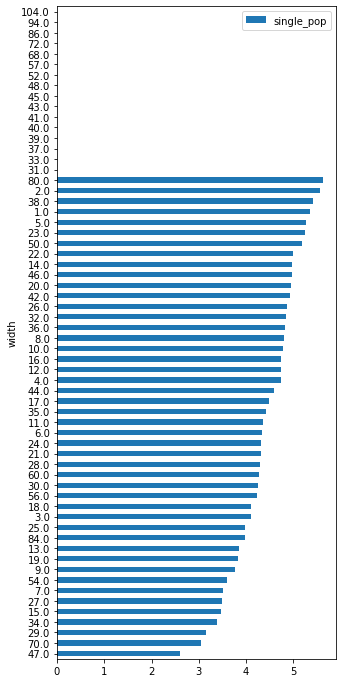

In [41]:
width_pop[['width','single_pop']].sort_values('single_pop').plot(x='width', kind = 'barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

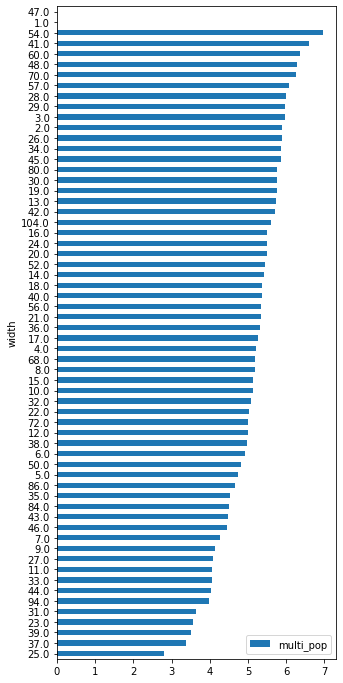

In [42]:
width_pop[['width','multi_pop']].sort_values('multi_pop').plot(x='width', kind = 'barh', figsize = (5,12))

Neither group particularly had the most frequent sizes among the most popular. It is likely popularity vs size only shows up within certain subgroups, if it is a predictor at all.

## Function
There are about 3k more multifunction modules than single function

In [43]:
df_brands.groupby('multifunction').size()

multifunction
False    2101
True     4965
dtype: int64

# Comparison of variables

## Popularity vs. single/multi-function

Conclusions:
Multifunction modules are significantly more popular. 

Quantizers, reverbs, samplers, function generators, and loopers all have high popularity but rank low in production. These are areas for possible growth.

Multifunction modules will be counted in every category they are contained in when looking at stats by function. 

We will also look at multi v. single function and popularity

Text(0.5, 1.0, 'Multifunction vs. Popularity')

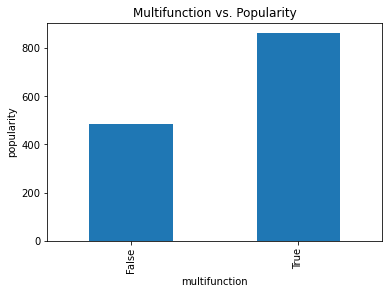

In [44]:
ax = df_brands.groupby('multifunction')['num_racks'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('popularity')
ax.set_title('Multifunction vs. Popularity')

We can clearly see that multifunction modules are more popular than single function. To verify:

In [45]:
multifunction_p = df_brands[df_brands.multifunction].loc[:,'num_racks'].values
singlefunction_p = df_brands[~df_brands.multifunction].loc[:,'num_racks'].values

In [46]:
ttest_ind(multifunction_p, singlefunction_p, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=8.063546919636027, pvalue=4.3445084120283227e-16)

In [47]:
# brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='functions'>

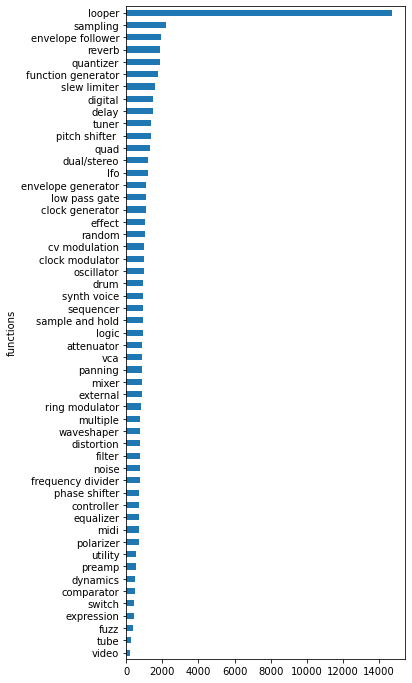

In [48]:
#All functions by popularity
brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [49]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

<AxesSubplot:ylabel='functions'>

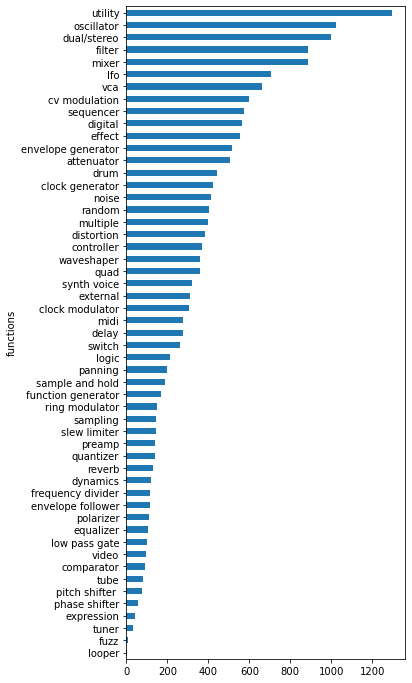

In [50]:
brands_exploded.groupby('functions')['module_name'].unique().apply(len).sort_values().plot(kind = 'barh', figsize = (5,12))

Quantizers, reverbs, samplers, function generators, and loopers all have high popularity but rank low in production. These are areas for possible growth.

In [51]:
# modules_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [52]:
brands_exploded.functions.unique().size

53

## Price and popularity

Price and popularity are almost completely decorrelated for both single and multifunction modules, with less than 25% (positive) correlation on both lin-lin and log-log scales. 

Since popularity and price are from distinct distributions for single and multi-function modules, we look at each independently.

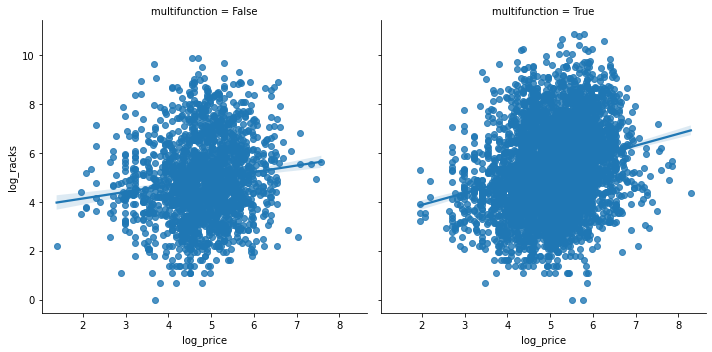

In [53]:
sns.lmplot(x = 'log_price', y = 'log_racks', data = df_brands[df_brands.price_known], col = 'multifunction')

It looks like there is a very weak positive correlation. We check numerically.

In [54]:
#Single function
df_brands[df_brands.price_known & (~df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks,pop_rank,num_functions,n_func_rank
price,1.000000,0.823255,0.038671,0.116730,0.086174,NaN,NaN
log_price,0.823255,1.000000,0.061312,0.133353,0.117974,NaN,NaN
num_racks,0.038671,0.061312,1.000000,0.637616,0.789640,NaN,NaN
log_racks,0.116730,0.133353,0.637616,1.000000,0.879479,NaN,NaN
pop_rank,0.086174,0.117974,0.789640,0.879479,1.000000,NaN,NaN
num_functions,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_func_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
#Multifunction
df_brands[df_brands.price_known & (df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks,pop_rank,num_functions,n_func_rank
price,1.000000,0.809995,0.059688,0.153549,0.116884,0.263048,0.262989
log_price,0.809995,1.000000,0.095564,0.225221,0.183167,0.305115,0.305088
num_racks,0.059688,0.095564,1.000000,0.563899,0.632756,0.140541,0.140678
log_racks,0.153549,0.225221,0.563899,1.000000,0.912424,0.167192,0.167481
pop_rank,0.116884,0.183167,0.632756,0.912424,1.000000,0.152543,0.152759
num_functions,0.263048,0.305115,0.140541,0.167192,0.152543,1.000000,0.999950
n_func_rank,0.262989,0.305088,0.140678,0.167481,0.152759,0.999950,1.000000


Surprisingly, increased price does not seem to lead to a decrease in popularity. The correlation does not reach 25% even in the log-transformed data, so we can see that these are roughly decorrelated.

## Size vs. popularity

Size has an irregular distribution, even when separating single and multi-function modules. We may have to look within-function(s) to see patterns, if they exist.

On the whole, there are not significant correlations between size and popularity within single and multifunction groups.

First check size vs. popularity in single and multi function modules.

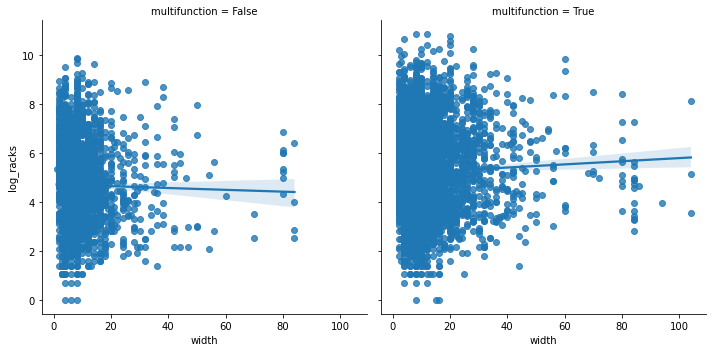

In [56]:
sns.lmplot(x = 'width', y = 'log_racks', data = df_brands, col = 'multifunction')

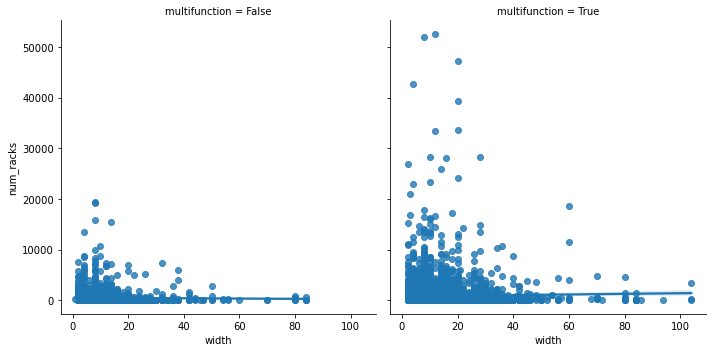

In [57]:
sns.lmplot(x = 'width', y = 'num_racks', data = df_brands, col = 'multifunction')

In [58]:
df_brands[~df_brands.multifunction][numeric].corr()

,width,price,log_price,num_racks,log_racks,pop_rank,num_functions,n_func_rank
width,1.000000,0.582195,0.493926,-0.020332,-0.020698,-0.025675,NaN,NaN
price,0.582195,1.000000,0.823255,0.038671,0.116730,0.086174,NaN,NaN
log_price,0.493926,0.823255,1.000000,0.061312,0.133353,0.117974,NaN,NaN
num_racks,-0.020332,0.038671,0.061312,1.000000,0.621931,0.791002,NaN,NaN
log_racks,-0.020698,0.116730,0.133353,0.621931,1.000000,0.865117,NaN,NaN
pop_rank,-0.025675,0.086174,0.117974,0.791002,0.865117,1.000000,NaN,NaN
num_functions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_func_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No significant correlations. We will have to look at size within smaller groups.

## Popularity of brands

In [59]:
#All functions by popularity
df_brands.groupby('manufacturer_name')['num_racks'].mean().sort_values(ascending=False).head(50)

manufacturer_name
Mutable instruments         20765.400000
DivKid                      14615.500000
Make Noise                   9107.326923
Intellijel                   8397.305085
Strymon                      7678.333333
Moog Music Inc.              6961.000000
Mannequins                   5105.111111
Expert Sleepers              4727.285714
Squarp Instruments           4641.666667
ALM Busy Circuits            4591.107143
Xaoc Devices                 3559.148148
Mordax                       3534.250000
Acid Rain Technology         3212.000000
Rossum Electro-Music         2998.750000
Joranalogue Audio Design     2945.625000
Five12                       2828.000000
Doepfer                      2673.248756
Verbos Electronics           2641.111111
ThreeTom Modular             2641.000000
Instruō                      2494.800000
Winter Modular               2388.333333
Epoch Modular                2305.000000
Rabid Elephant               2263.000000
Empress Effects              2206.00000

## Size, popularity, and function
XXX No obvious patterns indicating size determining popularity. Section set aside.

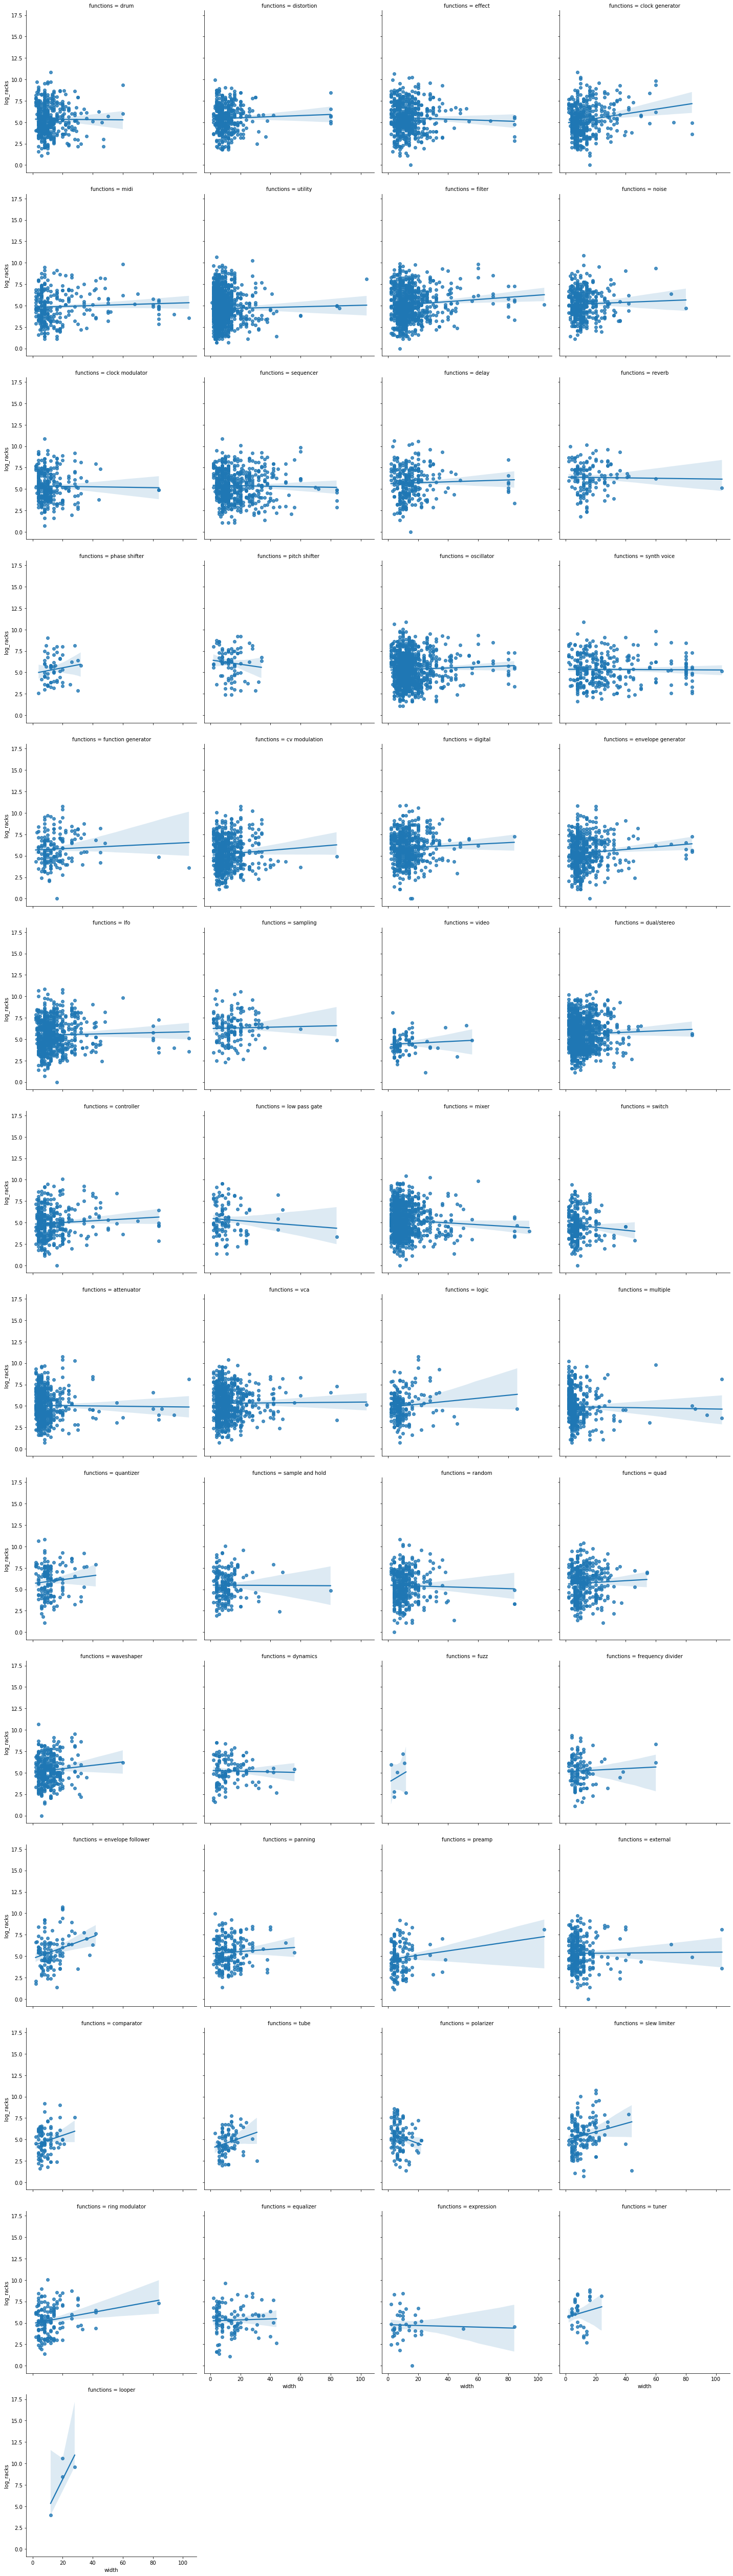

In [60]:
sns.lmplot(x = 'width', y = 'log_racks', data = brands_exploded, col = 'functions', col_wrap = 4)

Not much to be found
To begin analysis of size, we look for size outliers in each category.

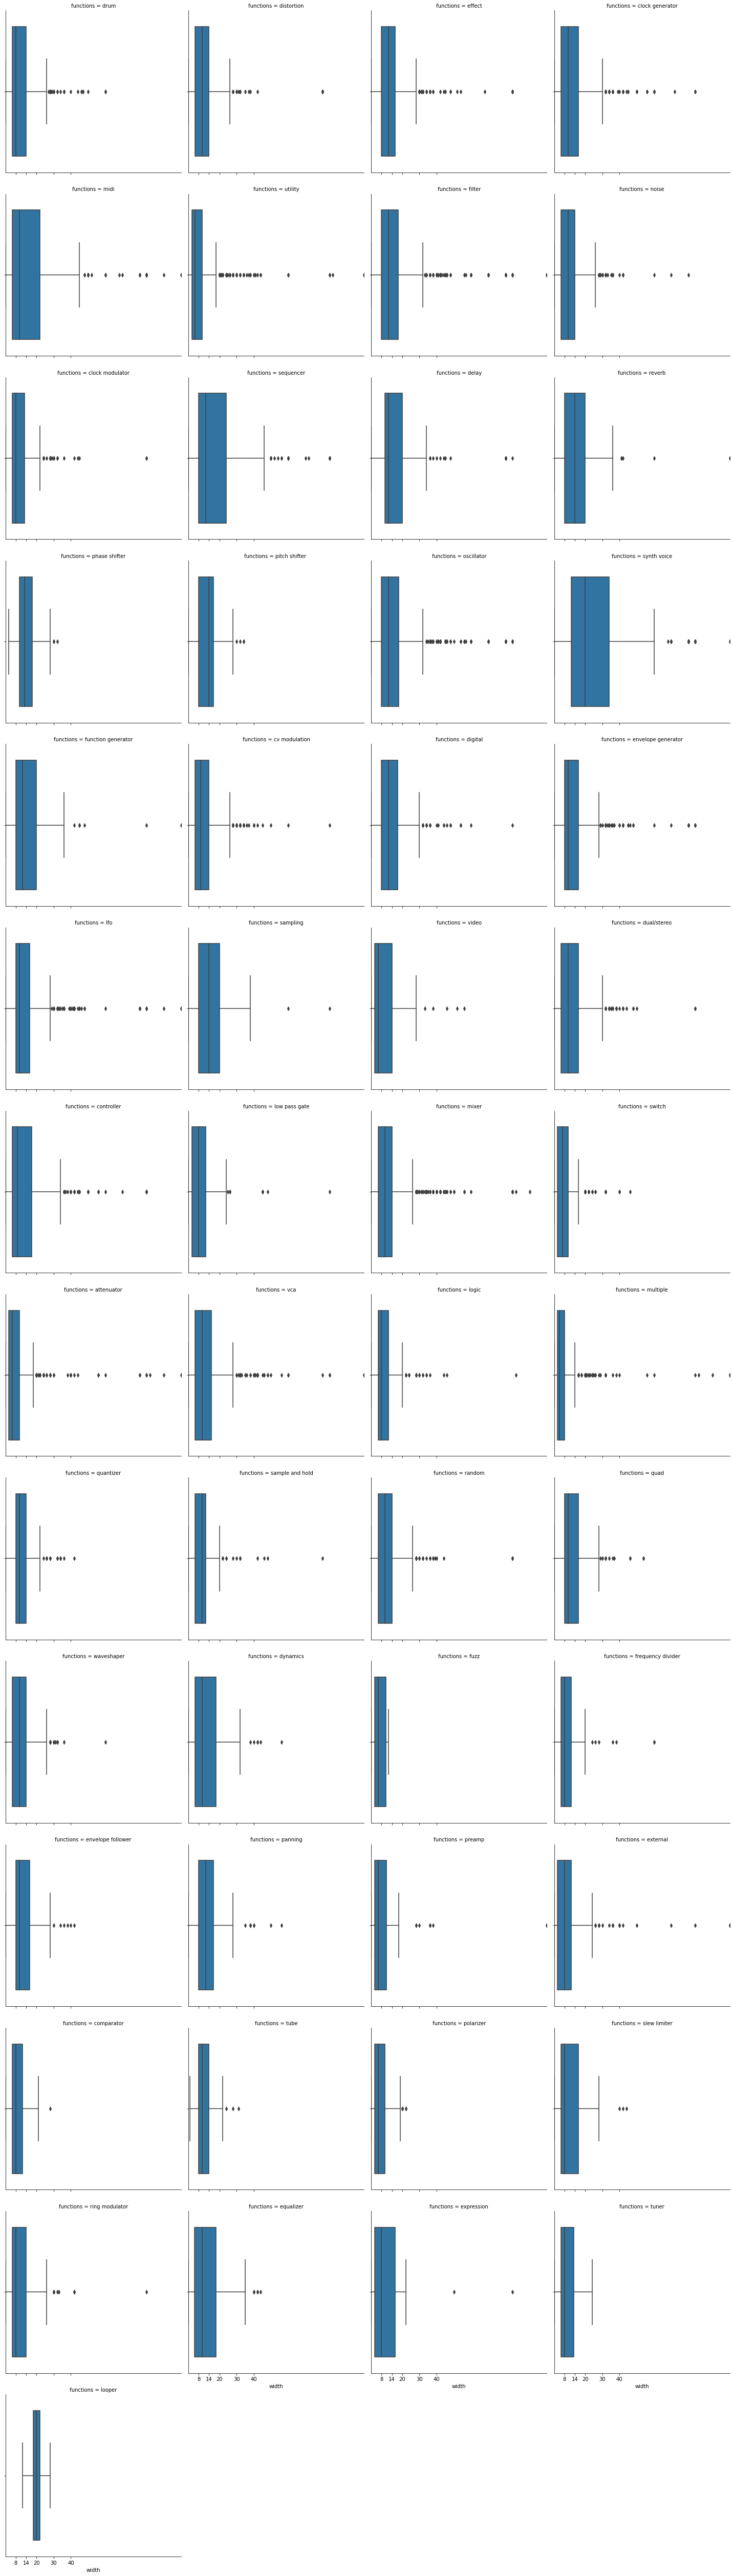

In [61]:
g = sns.catplot(x = 'width', col = 'functions', col_wrap = 4, data = brands_exploded, kind = 'box')
g.set(xlim = (2,np.max(brands_exploded.width)), xticks = [8, 14, 20, 30, 40])

The distribution of outliers over 1.5IQR above Q3 varies greatly between functions, suggesting that they may be different in each group. We should examine the outlier for each kind. This may be due to many factors, such as the outliers for certain functions being due to commonly being on multifunction modules, which may be larger.

In [62]:
function_widths = [*brands_exploded.groupby('functions')['width']]

In [63]:
#Inspecting outliers for each group may be too complicated
# print(function_widths[0][0])
# print(cutoff(function_widths[0][1]))
# np.array(function_widths[0][1:]).reshape(-1,)[(function_widths[0][1] > cutoff(function_widths[0][1:])).values]

# EDA summary and questions:
- popularity is log-normal
- price is loosely log-normal, with large tails and left skew. single function price is much closer to log-normal. less so for multi-function, which has a left skew.
- size is much more idiosyncratic, with multifunction with a significantly larger width by about 1.8 on average.


-multifunction are significantly more popular

-price and popularity are decorrelated

-size has no overall patterns with popularity, probably need more restricted product groups.

So, price is not a great predictor of popularity. We know that multifunctions modules are larger and more popular on the whole, but we will want to get a more in depth analysis by function. We want to look at relations between popularity, size, single vs. multi by function. 

- For each function, are multi-function modules containing that function more or less popular than their single-function counterparts? (multi, but some areas where single can compete)
-  Are there patterns among the popularity of brands based on the types or breadth of functions they produce? (no simple ones)
- For popular functions, are there many popular modules, are a few very popular modules? Are there functions which have more room before they're 'saturated'? (skipped)
- Do popular brands have many popular products accross functions, or do they tend to have more successful products within a category? (complex, partial analysis given below)


For multifunction:
- Popularity by number of functions
- Function pairings which result in highest popularity.

## Popularity by number of functions
The specific number of functions does not have a big impact on popularity.

<AxesSubplot:xlabel='num_functions', ylabel='log_racks'>

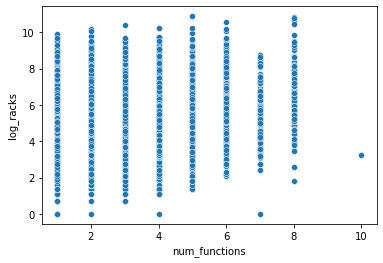

In [64]:
sns.scatterplot(data = df_brands, x='num_functions', y = 'log_racks')

<AxesSubplot:xlabel='n_func_rank', ylabel='pop_rank'>

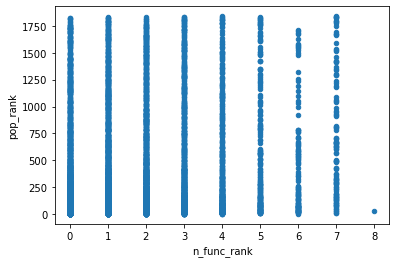

In [65]:
df_brands[['n_func_rank','pop_rank']].plot(kind='scatter',x='n_func_rank', y='pop_rank')

In [66]:
df_brands[['n_func_rank','pop_rank']].corr(method='spearman')

,n_func_rank,pop_rank
n_func_rank,1.000000,0.193598
pop_rank,0.193598,1.000000


Per-module, there is no strong correlation between ranking in number of features provided and ranking in popularity of the product.

## Are multi-function modules containing that function more or less popular than their single-function counterparts?

Results:

There are no types of functions where single-function modules have a significant advantage.

However, for brand name modules, there are some categories where they can rank similar to multifunction categories such as areas where they are already successful (video, switch, ...) but even some where multi has only an insigificant advantage (clock modulators, reverb, midi, and sampling)

ZZZ Design idea, show heatgrid of significance to show success of multifunction in each area.

In [67]:
functions = brands_exploded.functions.unique()

In [68]:
singledf = df_brands[~df_brands.multifunction]
multidf = df_brands[df_brands.multifunction]

In [69]:
#Check code for single function
# test_f = np.random.choice(singledf.tags)

# singledf_f = singledf[singledf.tags == test_f]
# multidf_f = multidf[multidf.tags.str.contains(test_f)]

# print(f'single function - multifunction for {test_f}:', np.mean(singledf_f.log_racks) - np.mean(multidf_f.log_racks))
# print('Probabilility of H0:',
#     ttest_ind(singledf_f.log_racks, multidf_f.log_racks, 
#               equal_var = False, random_state = 53, alternative = 'less').pvalue
#      )

In [70]:
def more_pop(n):
    if n<0:
        return 'multi'
    elif n>0:
        return 'single'
    elif n==0:
        return 'equal'
    else:
        return 'na'
    
def is_significant(p):
    if p<0.05:
        return True
    else:
        return False

In [71]:
func_testresults = pd.DataFrame(columns = ['function', 'avg_log_racks_single', 'avg_log_racks_multi', 'dif', 'pval'])

for function in functions:
    singledf_f = singledf[singledf.tags == function]
    multidf_f = multidf[multidf.tags.str.contains(function)]
    
    if any(singledf_f) & any(multidf_f):
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.mean(singledf_f.log_racks)], 
                                        'avg_log_racks_multi': [np.mean(multidf_f.log_racks)],
                                        'dif': [np.mean(singledf_f.log_racks) - np.mean(multidf_f.log_racks)],
                                        'pval':  [ttest_ind(singledf_f.log_racks, multidf_f.log_racks, 
                                                equal_var = False, random_state = 53, alternative = 'less').pvalue]})
    elif any(multidf_f):
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.nan], 
                                        'avg_log_racks_multi': [np.mean(multidf_f.log_racks)],
                                        'dif': [np.nan],
                                        'pval':  [np.nan]})
    else:
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.mean(singledf_f.log_racks)], 
                                        'avg_log_racks_multi': [np.nan],
                                        'dif': [np.nan],
                                        'pval':  [np.nan]})
    
    func_testresults = pd.concat([func_testresults, func_results])

func_testresults.reset_index(drop=True, inplace=True)
func_testresults['more_pop'] = func_testresults.dif.apply(more_pop)
func_testresults['significant'] = func_testresults.pval.apply(is_significant)

In [72]:
#Find places where single function has an advantage

func_testresults[func_testresults.more_pop == 'single']

,function,avg_log_racks_single,avg_log_racks_multi,dif,pval,more_pop,significant
22,video,4.859073,4.301304,0.557769,0.99377,single,False
27,switch,4.670271,4.643655,0.026616,0.537186,single,False
31,multiple,5.279726,4.777161,0.502565,0.995853,single,False
37,dynamics,5.224896,5.205584,0.019312,0.511804,single,False
39,frequency divider,6.328889,5.193496,1.135393,0.784241,single,False
44,comparator,6.884983,4.742513,2.14247,0.959063,single,False


There are no functions for which being single function is a popularity advantage.

In [73]:
#Find places where single may be able to compete

func_testresults[(func_testresults.more_pop == 'multi') & ~func_testresults.significant].sort_values(by = 'pval', ascending=False)

,function,avg_log_racks_single,avg_log_racks_multi,dif,pval,more_pop,significant
8,clock modulator,5.297054,5.336316,-0.039262,0.461775,multi,False
11,reverb,6.2388,6.358796,-0.119996,0.439944,multi,False
4,midi,4.827294,4.911555,-0.08426,0.382067,multi,False
21,sampling,6.122036,6.32426,-0.202224,0.302923,multi,False
13,pitch shifter,5.370108,6.121272,-0.751165,0.241205,multi,False
50,expression,3.646169,4.784164,-1.137996,0.238764,multi,False
41,panning,5.138284,5.443667,-0.305383,0.182,multi,False
51,tuner,5.541909,6.199879,-0.65797,0.171629,multi,False
30,logic,4.766134,5.064826,-0.298693,0.147076,multi,False
24,controller,4.659625,4.993631,-0.334007,0.068417,multi,False


## Are there patterns among the popularity of brands based on the types or breadth of functions they produce?

XXX no strong results

<AxesSubplot:>

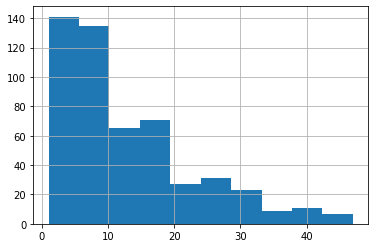

In [74]:
brand_data.n_functions.hist()

<AxesSubplot:>

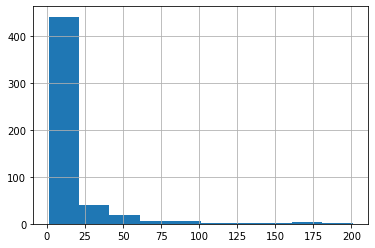

In [75]:
brand_data.n_modules.hist()

<AxesSubplot:>

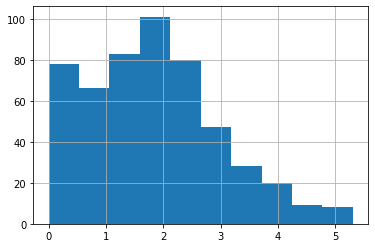

In [76]:
np.log(brand_data.n_modules).hist()

[Text(0.5, 1.0, 'Number of functions produced by brand vs. average product popularity of brand')]

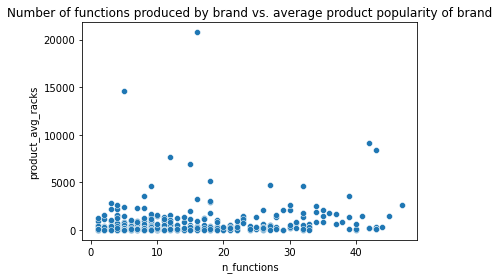

In [77]:
g = sns.scatterplot(data = brand_data, x='n_functions', y = 'product_avg_racks')
g.set(title = 'Number of functions produced by brand vs. average product popularity of brand')

[Text(0.5, 1.0, 'Number of functions produced by brand vs. max product popularity of brand')]

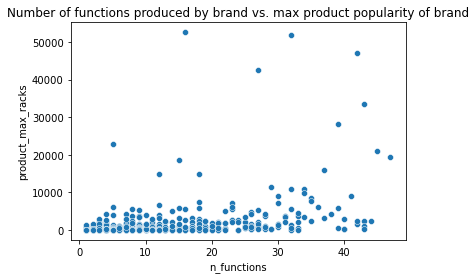

In [78]:
g = sns.scatterplot(data = brand_data, x='n_functions', y = 'product_max_racks')
g.set(title = 'Number of functions produced by brand vs. max product popularity of brand')

[Text(0.5, 1.0, 'Number of functions produced by brand vs. max product popularity of brand')]

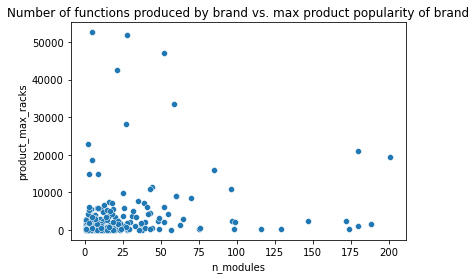

In [79]:
g = sns.scatterplot(data = brand_data, x='n_modules', y = 'product_max_racks')
g.set(title = 'Number of functions produced by brand vs. max product popularity of brand')

In [80]:
brand_data.drop('brand',axis=1).corr()

,n_functions,n_modules,product_avg_racks,product_max_racks,n_top_products,per_top_products
n_functions,1.000000,0.737548,0.177355,0.372657,0.390476,0.184071
n_modules,0.737548,1.000000,0.071281,0.252768,0.421362,0.088052
product_avg_racks,0.177355,0.071281,1.000000,0.814066,0.442307,0.831615
product_max_racks,0.372657,0.252768,0.814066,1.000000,0.649609,0.701711
n_top_products,0.390476,0.421362,0.442307,0.649609,1.000000,0.497434
per_top_products,0.184071,0.088052,0.831615,0.701711,0.497434,1.000000


# Some takeaways:
 - (product popularity) some gaps where there are highly popular functions, but comparatively few being developed
 - (price and popularity) price is not a strong correlate of popularity, suggesting that this is not a competative parameter
 - (single vs. multifunction and popularity) multifunction preferred to single function
 - (single vs. multifunction popularity per function) no function/use-areas where single-function has significant advantage, though some areas where they can compete
 
Further exploration:
- (set aside) optimal size(s) are likely relativized to function(s)
- (done in next section) look for successful function pairings

# Function pairing analysis

Strategy:
There are 53 functions so 53 * 52 = 2756 ordered pairs of distinct functions. We pose the pairing problem as follows:

For each pair of Eurorack functions (f,g), ask if the popularity of modules with both functions f and g significantly more popular than the modules with f but not g (though possibly paired with others). We can then see if there are gaps in production of modules with these pairings.

We can find these gaps in a similarly asymmetric way by looking at the ratio card({has both f and g})/card({has f}). If (f,g) is significantly more popular, but the ratio card({has both f and g})/card({has f}) is low, that means that there are many modules with f which could be improved by adding g. So, makers interested in making an f should definitely consider adding g in this category.

Some conclusions on functionality combinations:

- Many areas where a module with a function is greatly improved by adding a second, but low proportion of currently available modules have it
- Some suggestive combinations:
    - oscillators with onboard tuners have a great advantage, but represent less than 0.5% of available oscillators
    - adding onboard reverb to drums has a great advantage, also represents less than 0.5% of available drums
    - midi-video combo suggests people want general IO board, but few available
    - combo logic-envelope generator (likely due to maths) desirable, but underrepresented in each group.
    - of the popular but underproduced type 'sampling', adding distortion has a significant boost of popularity despite only being in 3.2% of sampling modules

In [81]:
functions

array(['drum', 'distortion', 'effect', 'clock generator', 'midi',
       'utility', 'filter', 'noise', 'clock modulator', 'sequencer',
       'delay', 'reverb', 'phase shifter', 'pitch shifter ', 'oscillator',
       'synth voice', 'function generator', 'cv modulation', 'digital',
       'envelope generator', 'lfo', 'sampling', 'video', 'dual/stereo',
       'controller', 'low pass gate', 'mixer', 'switch', 'attenuator',
       'vca', 'logic', 'multiple', 'quantizer', 'sample and hold',
       'random', 'quad', 'waveshaper', 'dynamics', 'fuzz',
       'frequency divider', 'envelope follower', 'panning', 'preamp',
       'external', 'comparator', 'tube', 'polarizer', 'slew limiter',
       'ring modulator', 'equalizer', 'expression', 'tuner', 'looper'],
      dtype=object)

In [82]:
#Create set of unique ordered pairs
pairs = set()
for pair in itertools.product(functions,functions):
    x,y = pair
    if x != y:
        pairs.add(pair)
len(pairs)

2756

In [83]:
#Returns subset of df_brands of modules with both functions
def func_and(func1, func2):
    return df_brands[df_brands.functions.apply(lambda x: (func1 in x) & (func2 in x))]

#Returns subset of df_brands of modules with first but not second function
def func_diff(func1,func2):
    return df_brands[df_brands.functions.apply(lambda x: (func1 in x) & (func2 not in x))]

In [84]:
# test1, test2 = np.random.choice(functions,size=2)
# print(f'test1 = {test1}, test2 = {test2} ')

In [85]:
# print(func_and(test1,test2).num_racks.mean())
# print(func_diff(test1,test2).num_racks.mean())
# print(func_and(test1,test2).num_racks.mean() - func_diff(test1,test2).num_racks.mean())
# print()

In [86]:
# ttest_ind(func_and(test1,test2).log_racks, func_diff(test1,test2).log_racks, equal_var = False, random_state = 53, alternative = 'greater').pvalue

In [87]:
#Says if modules with both features or just the first are more popular.
def more_pop_f(n):
    if n<0:
        return 'diff'
    elif n>0:
        return 'and'
    elif n==0:
        return 'equal'
    else:
        return 'na'
    
def is_significant_f(p):
    
    if p == 'f=>~g':
        return 'f=>~g'
    
    elif p == 'f=>g':
        return 'f=>g'
    
    else: 
        p = float(p)
        
        if p<0.05:
            return True
        else:
            return False
    

In [88]:
#Construct df showing results of testing average difference in popularity with both features or only first
pop_pair_test = pd.DataFrame(columns = ['function1', 'function2', 'avg_log_racks_and', 'avg_log_racks_diff', 'dif', 'pval'])

for pair in pairs:
    f,g = pair
    f_and_g = func_and(f,g)
    f_diff_g = func_diff(f,g)
    
    if (len(f_and_g)>0) &  (len(f_diff_g)>0):
        pair_results = pd.DataFrame({'function1': [f], 
                                     'function2': [g], 
                                        'avg_log_racks_and': [np.mean(f_and_g.log_racks)], 
                                        'avg_log_racks_diff': [np.mean(f_diff_g.log_racks)],
                                        'dif': [np.mean(f_and_g.log_racks) - np.mean(f_diff_g.log_racks)],
                                        'pval':  [ttest_ind(f_and_g.log_racks, f_diff_g.log_racks, 
                                                equal_var = False, random_state = 53, alternative = 'greater').pvalue]
                                    })  
    elif len(f_diff_g)>0:
        pair_results =  pd.DataFrame({'function1': [f], 
                                     'function2': [g], 
                                        'avg_log_racks_and': [np.nan], 
                                        'avg_log_racks_diff': [np.mean(f_diff_g.log_racks)],
                                        'dif': [-np.mean(f_diff_g.log_racks)],
                                        'pval':  ['f=>~g'] 
                                     })
    else:
        pair_results = pd.DataFrame({'function1': [f], 
                                     'function2': [g], 
                                        'avg_log_racks_and': [np.mean(f_and_g.log_racks)], 
                                        'avg_log_racks_diff': [np.nan],
                                        'dif': [np.mean(f_and_g.log_racks)],
                                        'pval':  ['f=>g'] 
                                     })
   
    
    pop_pair_test = pd.concat([pop_pair_test, pair_results])

pop_pair_test.reset_index(drop=True, inplace=True)
pop_pair_test['more_pop'] = pop_pair_test.dif.apply(more_pop_f)
pop_pair_test['significant'] = pop_pair_test.pval.apply(is_significant_f)


/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a

In [89]:
pop_pair_test

,function1,function2,avg_log_racks_and,avg_log_racks_diff,dif,pval,more_pop,significant
0,digital,synth voice,6.030598,5.930233,0.100365,0.287872,and,False
1,effect,looper,9.031147,5.487688,3.54346,0.048801,and,True
2,ring modulator,attenuator,5.304084,5.303264,0.00082,0.499322,and,False
3,video,sequencer,4.386086,4.473436,-0.08735,0.544107,diff,False
4,drum,mixer,5.172543,5.349588,-0.177045,0.545393,diff,False
...,...,...,...,...,...,...,...,...
2751,sampling,synth voice,6.160629,6.317463,-0.156835,0.629789,diff,False
2752,slew limiter,mixer,5.20796,5.483624,-0.275664,0.645508,diff,False
2753,cv modulation,phase shifter,4.917513,5.227097,-0.309584,0.568931,diff,False
2754,cv modulation,quantizer,6.159408,5.165382,0.994026,0.002744,and,True


In [90]:
#Subset function pairings where the popularity of modules with the first function
#is significantly improved by adding the second function
good_pairings = pop_pair_test[(pop_pair_test.more_pop == 'and') & pop_pair_test.significant]\
  .reset_index(drop=True).drop(['avg_log_racks_and', 'avg_log_racks_diff', 'pval', 'more_pop'], axis = 1)

In [91]:
good_pairings

,function1,function2,dif,significant
0,effect,looper,3.54346,True
1,dual/stereo,phase shifter,0.915819,True
2,tube,cv modulation,1.965435,True
3,drum,sampling,1.874761,True
4,digital,sampling,0.724216,True
...,...,...,...,...
439,quantizer,function generator,1.140617,True
440,drum,synth voice,0.405383,True
441,oscillator,clock generator,0.502384,True
442,utility,effect,0.596284,True


In [92]:
# df_brands.functions.apply(lambda x: test1 in x).sum()

In [93]:
# df_brands.functions.apply(lambda x: (test1 in x) & (test2 in x)).sum()

In [94]:
def func_prop(func1, func2):
    n_func1 = df_brands.functions.apply(lambda x: func1 in x).sum()
    n_both = df_brands.functions.apply(lambda x: (func1 in x) & (func2 in x)).sum()
    
    if n_both:
        return n_both / n_func1
    else:
        return 0

In [95]:
good_pairings_prop = good_pairings.copy()
good_pairings_prop['func_prop'] = pd.Series([*map(func_prop, good_pairings.function1, good_pairings.function2)])

In [96]:
#Check that test function applied correctly 
#test_row = np.random.randint(0,high = len(good_pairings))
# testf1, testf2, testprop = good_pairings_prop.iloc[test_row,:]
# func_prop(testf1,testf2) == testprop

In [97]:
import re

In [98]:
filter1 = good_pairings_prop.function1.apply(lambda x: re.match('dual/stereo|effect|external|controller|tube', x) == None)
filter2 = good_pairings_prop.function2.apply(lambda x: re.match('dual/stereo|effect|external|controller|tube', x) == None)
desc_mask = filter1 & filter2

In [99]:
good_pairings_prop[(good_pairings_prop.func_prop < 0.05) & desc_mask].sort_values(by = 'dif', ascending = False).head(10)

,function1,function2,dif,significant,func_prop
102,logic,envelope generator,3.645745,True,0.027523
39,envelope generator,logic,3.263949,True,0.010929
251,logic,slew limiter,3.203314,True,0.022936
346,filter,clock generator,2.816784,True,0.005470
338,clock modulator,tuner,2.815453,True,0.012862
299,slew limiter,logic,2.790382,True,0.034247
266,clock generator,filter,2.702268,True,0.011574
11,oscillator,tuner,2.659219,True,0.004735
123,drum,reverb,2.571761,True,0.004376
157,utility,sampling,2.56013,True,0.005323


In [100]:
good_pairings_prop['dif/prop advantage'] = good_pairings_prop.dif / good_pairings_prop.func_prop

In [101]:
good_pairings_prop[filter1 & filter2].sort_values('dif/prop advantage', ascending = False).head(20)

,function1,function2,dif,significant,func_prop,dif/prop advantage
123,drum,reverb,2.571761,True,0.004376,587.64744
11,oscillator,tuner,2.659219,True,0.004735,561.626993
346,filter,clock generator,2.816784,True,0.005470,514.908178
157,utility,sampling,2.56013,True,0.005323,480.938756
327,mixer,function generator,1.507762,True,0.004367,345.277591
359,utility,equalizer,1.811943,True,0.005323,340.386385
39,envelope generator,logic,3.263949,True,0.010929,298.651315
328,filter,frequency divider,1.561102,True,0.005470,285.369438
128,sequencer,polarizer,0.910836,True,0.003390,268.696626
85,noise,frequency divider,1.151658,True,0.004728,243.575761


Example: popularity jumps by over a standard deviation by adding reverb to drum, but represents less than 0.5% of drum modules. Similar for oscillators adding tuners.

## Examples for specific functions

In [102]:
good_pairings_prop[good_pairings_prop.function1 == 'sampling'].sort_values(by='dif', ascending = False)

,function1,function2,dif,significant,func_prop,dif/prop advantage
183,sampling,distortion,1.73534,True,0.032680,53.101413
242,sampling,drum,0.982736,True,0.176471,5.56884
320,sampling,dual/stereo,0.956401,True,0.215686,4.434224
150,sampling,digital,0.519364,True,0.470588,1.103649
284,sampling,delay,0.502613,True,0.333333,1.50784


In [103]:
good_pairings_prop[good_pairings_prop.function1 == 'sampling'].sort_values(by='dif/prop advantage', ascending = False)

,function1,function2,dif,significant,func_prop,dif/prop advantage
183,sampling,distortion,1.73534,True,0.032680,53.101413
242,sampling,drum,0.982736,True,0.176471,5.56884
320,sampling,dual/stereo,0.956401,True,0.215686,4.434224
284,sampling,delay,0.502613,True,0.333333,1.50784
150,sampling,digital,0.519364,True,0.470588,1.103649


Since sampling is a highly popular type of module, but comparatively few are made, a brand might wonder what features to pair with one. We can see that adding distortion increases popularity by about a standard deviation, though only represented in 3.2% of sampling modules.

In [104]:
good_pairings_prop[good_pairings_prop.function1 == 'looper'].sort_values(by='dif', ascending = False)

,function1,function2,dif,significant,func_prop,dif/prop advantage
87,looper,delay,8.153019,f=>g,1.0,8.153019
231,looper,sampling,8.153019,f=>g,1.0,8.153019


David's idea: see if any of these missing functions are unavailable from the largest brands

In [146]:
#Get brands in top 5% of producers
cutoff_ = brand_data.n_modules.mean() + 2 * brand_data.n_modules.std()
brands_most = set(brand_data[brand_data.n_modules >= cutoff_].brand.values)

In [243]:
#Input list of functions, get back df of products with ALL of those functions
def get_modules_by_features(*args):
    results = pd.Series(index = range(len(df_brands)), dtype = bool).values
    for arg in args:
        result = df_brands.functions.apply(lambda x: arg in x).values
        results = np.logical_and(results,result)
    return df_brands[results]

#Return True if a high-production brand already makes product with all input features, false otherwise
def made_by_top_brand(*args):
    if set(get_modules_by_features(*args).manufacturer_name.unique()).intersection(brands_most):
        return True
    else:
        return False

In [256]:
good_pairings_prop['made_by_top_brand'] = [*map(made_by_top_brand, good_pairings_prop.function1,good_pairings_prop.function2)]

In [268]:
#Filter the good function pairings by excluding descriptors (tube, external,...)
#Only look at pairings (f,g) where f occurs both with and without g
#Filter out pairings already made by top producers
#Sort by advantage
#Drum + reverb, oscillator + tuner, logic + envelope generator, midi+video, and distortion + sample still in list
#Indicating these are areas for small manufacturers to stay competative
good_pairings_prop[desc_mask & (good_pairings_prop.significant != 'f=>g') & ~good_pairings_prop.made_by_top_brand]\
    .sort_values(by='dif/prop advantage', ascending=False).head(20)

,function1,function2,dif,significant,func_prop,dif/prop advantage,made_by_top_brand
123,drum,reverb,2.571761,True,0.004376,587.64744,False
11,oscillator,tuner,2.659219,True,0.004735,561.626993,False
346,filter,clock generator,2.816784,True,0.005470,514.908178,False
157,utility,sampling,2.56013,True,0.005323,480.938756,False
327,mixer,function generator,1.507762,True,0.004367,345.277591,False
359,utility,equalizer,1.811943,True,0.005323,340.386385,False
39,envelope generator,logic,3.263949,True,0.010929,298.651315,False
128,sequencer,polarizer,0.910836,True,0.003390,268.696626,False
85,noise,frequency divider,1.151658,True,0.004728,243.575761,False
266,clock generator,filter,2.702268,True,0.011574,233.475984,False


# Are the most popular products from a brand more likely to reach top 5% product status if they specialize or target many features?

Results: The ideal time for introducing redundancy into the higher-performing areas is when a brand is producing between 15-50 products. Outside this range the benefit of redundancy in the product line is less singificant than simply producing more modules. Once a brand is producing 100+ modules, high redundancy is again tolerated, allowing more top products.

We want to define a metric of amount of 'redundancy' of functionality in each company's products in the top 5%

(aside: we may want to do this for each of their individual relative top products or products which reach a certain level of popularity)

For a given collection of products, we want a metric which describes how much redundancy in functionality there is in the collection.

We first consider the assignment of any collection of products to a series indexed by functions, which gives the number of modules in the collection which have that function. For example, in the collection of modules in the top 5% made by a brand, if there are 3 modules which share the function 'lfo', then the coordinate indexed by 'lfo' will be 3 for that collection.

To get a single number representing the overall redundancy in the collection, we can take the product of all of these numbers, which captures how many times products overlap per function. If there is no redundancy in the collection, this number will be 1. If there are n products overlapping on m features, this number will be nm. This property is 'exponential' in that if we have two collections of products with disjoint functionality with redundancy values n and m, their 'sum' - the overall collection - will have redundancy number nm. 

Since we would like collections with no redundancy to have redundancy number 0, and we would like this to be additive with collections of products with disjoint features, we take the log.

In [105]:
#Errors in applying the metric in this section. Retained only for code defining metric and application to overall redundancy.

In [106]:
#Function takes in a dataframe of products exploded by function, and computes the number described above
#Float conversion is to deal with large numbers before log is taken
def redundant_products(product_df):
    return np.log(np.product(product_df.groupby('functions')['module_name']\
                             .unique().apply(len).astype('float').values))

In [107]:
#We first add this redundancy information for overall catalog by each brand.
#This gives a sense of how redundant the products are in a brand's catalog per function.
brand_data = brand_data.merge(
brands_exploded.groupby('manufacturer_name').apply(redundant_products).reset_index().rename(columns={0:'prod_redundancy'}),
                 left_on = 'brand', right_on = 'manufacturer_name', how='left').drop('manufacturer_name',axis=1)

In [108]:
brand_data.prod_redundancy.mean()

7.897898433371802

In [109]:
brand_data.prod_redundancy.median()

2.772588722239781

## Erroneous section - omit

In [110]:
# test_brand = np.random.choice(df_brands.manufacturer_name.unique())
# test_prod = brands_exploded[brands_exploded.manufacturer_name == test_brand]
# len(test_prod)

In [111]:
# redundant_products(test_prod)

In [112]:
# brand_data.merge(
#     top_products.explode('functions').groupby('manufacturer_name')\
#         .apply(redundant_products).reset_index().rename(columns={0:'top_prod_redundancy'}),
#      left_on = 'brand', right_on = 'manufacturer_name', how='left').drop('manufacturer_name',axis=1)

In [113]:
# brands_top_prod = brand_data.merge(
#     top_products.explode('functions').groupby('manufacturer_name')\
#         .apply(redundant_products).reset_index().rename(columns={0:'top_prod_redundancy'}),
#      left_on = 'brand', right_on = 'manufacturer_name', how='inner').drop('manufacturer_name',axis=1)

In [114]:
# brands_top_prod.plot(x='n_top_products', y='top_prod_redundancy', kind = 'scatter')

In [115]:
# n_prod_ranker = pairs_to_map([*zip(brands_top_prod.n_top_products.sort_values().unique(),
#       range(len(brands_top_prod.n_top_products.sort_values().unique())))])
# brands_top_prod['top_prod_rank'] = brands_top_prod.n_top_products.apply(n_prod_ranker)

In [116]:
# top_red_ranker = pairs_to_map([*zip(brands_top_prod.top_prod_redundancy.sort_values().unique(),
#       range(len(brands_top_prod.top_prod_redundancy.sort_values().unique())))])
# brands_top_prod['top_red_rank'] = brands_top_prod.top_prod_redundancy.apply(top_red_ranker)

In [117]:
# prod_red_ranker = pairs_to_map([*zip(brands_top_prod.prod_redundancy.sort_values().unique(),
#       range(len(brands_top_prod.prod_redundancy.sort_values().unique())))])
# brands_top_prod['prod_red_rank'] = brands_top_prod.prod_redundancy.apply(prod_red_ranker)

In [118]:
# brands_top_prod.iloc[:,-3:].corr(method = 'spearman')

In [119]:
# It is to be expected that past a certain point of top products, redundancy would have to occur. However, this trend only holds with brands with more than about 15 top products. There are still many brands with top products which don't have particularly high redundancy.

In [120]:
# brand_data.plot(kind='scatter', x='n_top_products', y='prod_redundancy')

In [121]:
# brand_data.plot(kind='scatter', x='prod_redundancy', y='per_top_products')

## Analysis of redundancy in top n products within brand

In [122]:
def top_n_redundant(brand_,n):
    top_n = df_brands[df_brands.manufacturer_name == brand_].sort_values('num_racks').iloc[0:n,:]
    return redundant_products(top_n.explode('functions'))

def top_n_df(n):
    geq_n = brand_data[brand_data.n_modules >=n]
    name_ = f'top_{n}_red'
    geq_n[name_] = geq_n.brand.apply(lambda x: top_n_redundant(x,n))
    
    return geq_n

def top_n_rank_df(n):
    geq_n = top_n_df(n)
    name_ = f'top_{n}_red'
    name_2 = name_+'_rank'
    
    top_ranker = pairs_to_map([*zip(geq_n.n_top_products.sort_values().unique(),
                                    range(len(geq_n.n_top_products.sort_values().unique())))])
    
    red_ranker = pairs_to_map([*zip(geq_n[name_].sort_values().unique(),
                     range(len(geq_n[name_].sort_values().unique())))])
                                
    geq_n['top_prod_rank'] = geq_n.n_top_products.apply(top_ranker)
    geq_n[name_2] = geq_n[name_].apply(red_ranker)
    
    return geq_n.loc[:,['top_prod_rank', name_2]]
    

def plot_top_n(n):
    name_ = f'top_{n}_red'
    top_n_df(n).loc[top_n_df(n).n_top_products > 0].loc[:,['n_top_products', name_]]\
        .plot(kind='scatter', x=name_, y='n_top_products')

In [123]:
red_top_results = []
for k in range(2,brand_data.n_modules.max()):
    red_top_results.append(top_n_rank_df(k).corr(method = 'spearman').iloc[0,1])

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/2120800172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geq_n[name_] = geq_n.brand.apply(lambda x: top_n_redundant(x,n))
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/2120800172.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geq_n['top_prod_rank'] = geq_n.n_top_products.apply(top_ranker)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_37542/2120800172.py:24: SettingWithCopyWarning: 
A value is trying 

### Find rank correlation between number of products made and number of top products

In [124]:
n_ranker = pairs_to_map([*zip(brand_data.n_modules.sort_values().unique(),
                                    range(len(brand_data.n_modules.sort_values().unique())))])
brand_data['n_prod_rank'] = brand_data.n_modules.apply(n_ranker)

In [125]:
top_ranker = pairs_to_map([*zip(brand_data.n_top_products.sort_values().unique(),
                                    range(len(brand_data.n_top_products.sort_values().unique())))])
brand_data['n_top_rank'] = brand_data.n_top_products.apply(top_ranker)

In [126]:
n_top_corr = brand_data.loc[:,['n_prod_rank','n_top_rank']].corr(method='spearman').iloc[0,1]

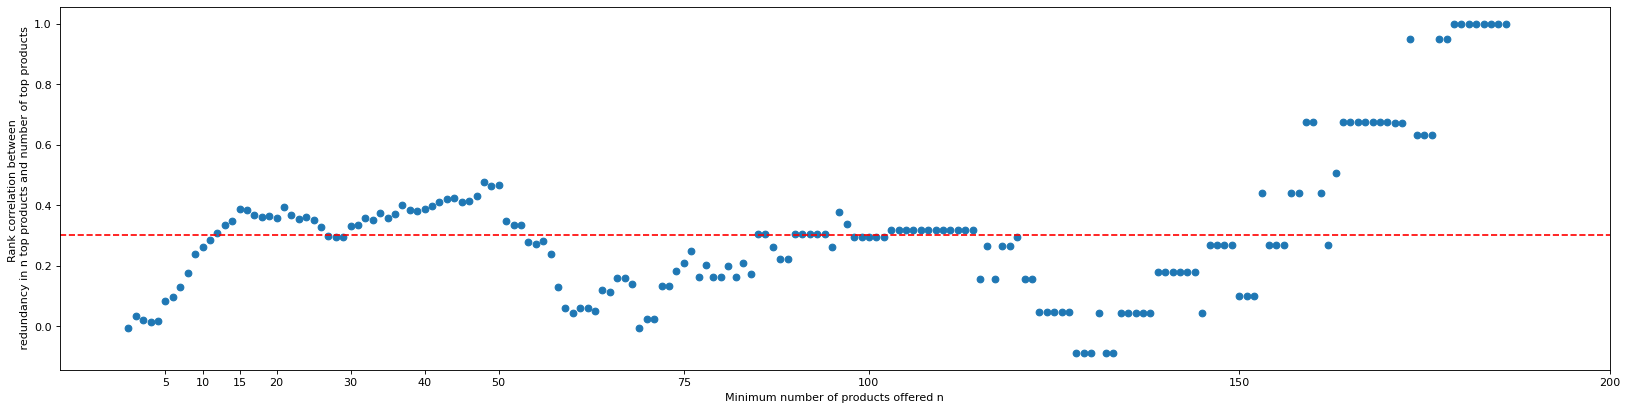

In [127]:
fig = plt.figure(figsize=(25, 6), dpi=80)
plt.scatter(x = range(len(red_top_results)), y = red_top_results)
plt.xlabel('Minimum number of products offered n')
plt.ylabel('Rank correlation between \n redundancy in n top products and number of top products')
plt.xticks([5,10,15,20,30,40,50,75,100,150,200])
plt.axhline(y=n_top_corr, color='r', linestyle='--')

The chart gives a rough measure of when companies producing a certain number of modules will have more products reach top product status by adding redundancy in their product line. Below 5 modules, redundancy among top products does not correlate with having more top products. In the zone of producing 15-50 modules, the brand is more likely to be able to sustain many top products with overlapping functionality. However, this drops again in the 50-75 modules range. Past the range, the values are less meaningful, since high redundancy becomes inevitable. Below the red line, this correlation is no stronger than just with the number of products made, so between 15-50 products is ideal for introducing redundancy into the higher-performing areas.